Aim: Find lowest eigen value of a unitary matrix

# Steps:
<ol>
    <li> Describe the Hamiltonian </li>
    <li> Find the lowest state, reference value </li>
    <li> Define parameters for ansatz </li>
    <li> Define Ansatz </li>
    <li> Define Measurements 
        <ol>
            <li> Define the circuit block </li>
            <li> Measure on the quantum computer </li>
            <li> Define the expectation value from the measurment results above</li>
        </ol>
    </li>
    <li>classical part: Run the optimizer</li>
    <li> Find the estimated lowest eigen value and compare it with the reference value of the step2.
</ol>

Reference : https://www.nature.com/articles/ncomms5213
https://www.youtube.com/watch?v=stkCUBBiK24

In [14]:
import numpy as np
from random import random
# This is a sparse representation of an N-qubit matrix Operator in terms of N-qubit PauliList and complex coefficients.
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute
from scipy.optimize import minimize

# Define Hamiltonian

In [70]:
# We need to express Hamiltonian as sum of pauli operatots xyz and tensor product for multi qubit system
a = 0.1* random()
b = 0.1 * random()
c = 0.1 * random()

hamiltonian = SparsePauliOp.from_list([("I", a), ("Z", b), ("X", c), ("Y", 1)])
hmat = hamiltonian.to_matrix()
hamiltonian

SparsePauliOp(['I', 'Z', 'X', 'Y'],
              coeffs=[0.02361414+0.j, 0.08928326+0.j, 0.05387978+0.j, 1.        +0.j])

# 

In [11]:
min_val_for_hamiltonian = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)
min_val_for_hamiltonian.eigenvalue

-0.9650304739989679

# Define Ansatz

In [62]:
params = np.array([np.pi/2, np.pi/3, np.pi, np.pi*0.9])
# params = np.array([np.pi/2 * 9])
tolerance = 1e-1

In [63]:
def ansatz_prep(circuit, params):
    q = circuit.qregs[0]
    circuit.rx(params[0], q[0])
    circuit.ry(params[1], q[0])
    circuit.rz(params[2], q[0])

    return circuit

# Define Measurment

## Circuit Block

In [64]:
def vqe_circuit_block(params, op):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    ansatz_prep(circuit, params)

    if op == "Z":
        circuit.measure(q[0], c[0])
    elif op == "X":
        circuit.h(0)
        circuit.measure(q[0], c[0])
    elif op == "Y":
        circuit.sdg(0)
        circuit.h(0)
        circuit.measure(q[0], c[0])

    return circuit

## Measurment on Quantum Computer

If I run a quantum circuit and get the counts dictionary on qiskit, I get observables in the Z basis.

For n=1 qubits, the basis states returned are |0⟩
 & |1⟩
 with the counts for each state. I would assign +1 to the counts for |0⟩
 and -1 to the counts for |1⟩
 and work out the Z expectation value.

For n=2 qubits, |00⟩
 & |11⟩
 have eigenvalues +1 and |01⟩
 &|10⟩
 have eigenvalues -1. The Z expectation value is thus [counts(00) + counts(11) - counts(01) - counts (10) ]/ shots where counts(00) is the counts returned for the |00⟩
 state.

This is extended to n = 3,4,5.. qubits.

In [65]:
def calc_expectation_value(counts, shots):
    exp_val = 0.0
    for ct in counts:
        sign = +1
        if ct == "1":
            sign = -1
        exp_val = exp_val + sign*counts[ct]/shots
    return exp_val

In [66]:
def quantum_term(params, ops):
    if ops == "I":
        return 1
    elif ops == "Z":
        circuit = vqe_circuit_block(params, ops)
    elif ops == "X":
        circuit = vqe_circuit_block(params, ops)
    elif ops == "Y":
        circuit = vqe_circuit_block(params, ops)
    

    shots = 8192
    backend = BasicAer.get_backend("qasm_simulator")
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return calc_expectation_value(counts, shots)

## Optimizer

In [67]:
def vqe_opt(params):
    hlist = hamiltonian.to_list()
    circuit_sum = 0
    for i in range(len(hlist)):
        circuit_sum += hamiltonian.coeffs[i].real * quantum_term(params, hlist[i][0])

    return circuit_sum

## Run optimizer

In [68]:
# COBYLA - Linear approximation
vqe_res = minimize(vqe_opt, params, method="COBYLA", tol=tolerance)

In [69]:
print("Estimated eigen value for the hamiltonian from the optimiser is:", vqe_res.fun)
print("The reference eigen value for the hamiltonian corresponding to lowest energy is", min_val_for_hamiltonian)

Estimated eigen value for the hamiltonian from the optimiser is: -0.9605971105056614
The reference eigen value for the hamiltonian corresponding to lowest energy is {   'aux_operators_evaluated': None,
    'eigenstate': Statevector([-0.68616404+0.j        ,  0.01080491+0.72736659j],
            dims=(2,)),
    'eigenvalue': -0.9650304739989679}


In [41]:
def energy_expectation(x, y):
    energy = np.zeros(x.shape)
    for idx, thetas in enumerate(x):
        for ind, theta1 in enumerate(thetas):
            params = np.array([np.pi/2, np.pi, theta1, y[idx][ind]])
            energy[idx][ind] = vqe_opt(params)
    return energy

theta1 = np.linspace(0.0, 2*np.pi, 20)
theta2 = np.linspace(0.0, 2*np.pi, 20)

X, Y = np.meshgrid(theta1, theta2)
Z = energy_expectation(X, Y)

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

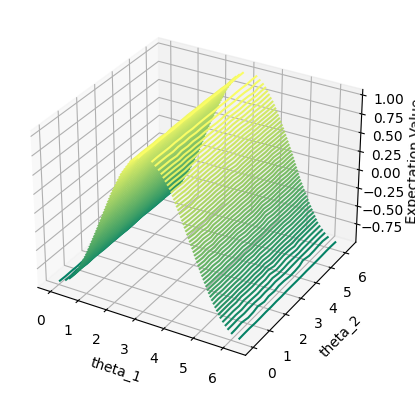

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap="summer")
ax.set_xlabel('theta_1')
ax.set_ylabel('theta_2')
ax.set_zlabel('Expectation Value');
plt.show()
